In [1]:
import InputGenerator
import base_model
import keras
import pandas as pd
import numpy as np
import baseline_model
import importlib
import setGPU

Using TensorFlow backend.


setGPU: Setting GPU to: 0


/usr/local/lib64/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
import InputBatchGenerator

In [3]:
import test_generator

In [4]:
importlib.reload(InputGenerator)

<module 'InputGenerator' from '/nfshome/llayer/AIErrorLogAnalysis/training/InputGenerator.py'>

In [5]:
importlib.reload(InputBatchGenerator)

<module 'InputBatchGenerator' from '/nfshome/llayer/AIErrorLogAnalysis/training/InputBatchGenerator.py'>

In [6]:
gen = InputGenerator.InputGenerator('/nfshome/llayer/data/actionshistory_300719.json')

In [7]:
gen.set_labels()

In [8]:
gen.actionshistory.head()

,task_name,errors,parameters,action,action_binary_encoded,splitting,splitting_encoded,xrootd,xrootd_encoded,memory,memory_encoded,action_encoded,action_split,action_split_encoded,action_binary
0,/amaltaro_Run2016D-v2-DoubleMuonLowMass-07Aug1...,"{'good_sites': {}, 'bad_sites': {'-1': {'T3_US...","{'action': 'acdc', 'sites': ['T1_US_FNAL'], 'm...",acdc,0,1x,0,NaN,2,,3,0,acdc_1x,2,acdc
1,/amaltaro_Run2016D-v2-DoubleMuonLowMass-07Aug1...,"{'good_sites': {}, 'bad_sites': {'-1': {'T3_US...","{'action': 'acdc', 'sites': ['T1_US_FNAL'], 'm...",acdc,0,1x,0,NaN,2,,3,0,acdc_1x,2,acdc
2,/amaltaro_Run2016D-v2-DoubleMuonLowMass-07Aug1...,"{'good_sites': {}, 'bad_sites': {'-1': {'T3_US...","{'action': 'acdc', 'sites': ['T1_US_FNAL'], 'm...",acdc,0,1x,0,NaN,2,,3,0,acdc_1x,2,acdc
3,/amaltaro_Run2018A-v1-DoubleMuon-17Sep2018_102...,"{'good_sites': {'85': {'T1_UK_RAL': 1}}, 'bad_...","{'action': 'acdc', 'cores': '', 'xrootd': 'ena...",acdc,0,1x,0,enabled,0,,3,0,acdc_1x,2,acdc
4,/amaltaro_Run2018A-v1-DoubleMuon-17Sep2018_102...,"{'good_sites': {'50664': {'T2_DE_RWTH': 2}, '-...","{'action': 'acdc', 'cores': '', 'sites': ['T2_...",acdc,0,1x,0,NaN,2,,3,0,acdc_1x,2,acdc


In [9]:
gen.set_padded_tokens()

In [10]:
gen.get_input_shape()

(33586, 77, 154, 200)

In [11]:
importlib.reload(test_generator)

<module 'test_generator' from '/nfshome/llayer/AIErrorLogAnalysis/training/test_generator.py'>

In [12]:
test_generator.test_count_matrix(gen, 2)

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold

In [143]:
import nlp_model

In [144]:
importlib.reload(nlp_model)

<module 'nlp_model' from '/nfshome/llayer/AIErrorLogAnalysis/training/nlp_model.py'>

In [231]:
importlib.reload(base_model)
importlib.reload(baseline_model)
importlib.reload(nlp_model) 
importlib.reload(InputBatchGenerator)

class FitHandler(object):
    
    def __init__(self, gen):
        
        self.gen = gen
        self.dim_tasks, self.dim_errors, self.dim_sites, self.dim_msg = gen.get_input_shape()
        self.sites = gen.sites_to_tiers(gen.sites) # gen.sites
        self.codes = gen.codes
        #print (self.sites)
        
        
    def print_sample_summary(self, frame):
        
        print(frame.value_counts())
        
    
    def split_frame(self, label, split_level):
        
        train, test, _, _ = train_test_split(gen.actionshistory, gen.actionshistory[label], test_size=split_level)
        return train, test
        
    def k_fold_indices(self, kfold_function=KFold, kfold_splits=5, verbose=0):
        
        enum = enumerate(kfold_function(n_splits=kfold_splits, shuffle=True, random_state=seed).split(X,Y))
        if verbose != 0:
            enum = tqdm(enum, total=kfold_splits, desc='kfold', leave=False, initial=0)
        return enum
        
    def fit_base_model(self, label, batch_size = 100, test_split=0.2, val_split=0.2, verbose=0):
        
        
        # Split in train and test frames
        train, test = self.split_frame(label, test_split)
        
        #self.print_sample_summary(train[label]) 
        #self.print_sample_summary(test[label]) 
        
        # Setup the generator of the input batches
        train_gen = InputBatchGenerator.InputBatchGenerator(train, label, self.codes, self.sites, self.dim_msg)
        test_gen = InputBatchGenerator.InputBatchGenerator(test, label, self.codes, self.sites, self.dim_msg)        
        X_train, y_train = train_gen.count_matrix(sum_good_bad = True)
        X_test, y_test = test_gen.count_matrix(sum_good_bad = True)
        
        print(type(y_test))
        
        print(X_train.shape)
        print(X_test.shape)
        #print(np.unique(y_train), return_counts = True)
        #print(np.unique(y_test), return_counts = True)
        
        uniqueValues, occurCount = np.unique(y_test, return_counts=True)
        print(uniqueValues, occurCount)
        # Set the baseline model
        n_sites = len(list(set(self.sites.values())))
        model = baseline_model.FF(2, self.dim_errors, n_sites)
        
        
        
        #history = model.train(X_train, y_train, X_test, y_test, max_epochs = 200, batch_size = 100, early_stopping = True)
        
        #return history
        
        
        model.find_optimal_parameters(X_train, y_train, X_test, y_test, max_epochs = 100, batch_size = 100, num_calls=20)

        
    def fit_nlp_model(self, label, batch_size = 1, test_split=0.2, val_split=0.2, verbose=1):

        # Set the baseline model
        model = nlp_model.NLP_Model(2, self.dim_errors, self.dim_sites, self.dim_msg)            
        #model.print_summary()
        
        # Split in train and test frames
        train, test = self.split_frame(label, test_split)
        
        # Setup the generator of the input batches
        train_gen = InputBatchGenerator.InputBatchGenerator(train, label, \
                                                            batch_size, self.codes, self.sites, self.dim_msg)
        test_gen = InputBatchGenerator.InputBatchGenerator(test, label, \
                                                            batch_size, self.codes, self.sites, self.dim_msg) 
        
        """
        for x,y in train_gen.gen_inf_count_msg_batches():
            print( x[0].shape )
        """
        
        steps_per_epoch = int(float(len(train)) / float(batch_size))
        validation_steps = int(float(len(test)) / float(batch_size))
        
        model.train_on_batch(training_generator = train_gen, validation_generator = test_gen, 
                             epochs = 1, steps_per_epoch = steps_per_epoch, validation_steps = validation_steps )
        
        

In [232]:
handler = FitHandler(gen)

T2
T1
T0
T2
Un
T2
T1
T2
T2
T1
T2
T2
T1
T3
T3
T2
T3
T2
T3
T3
T2
T3
T1
T3
T3
T3
T2
T2
T1
T2
T2
T1
T3
T0
T2
T2
T2
T3
T1
T3
T1
T3
T3
T3
T2
T1
T3
T3
T1
T2
T2
T2
T3
T3
T1
T2
T3
T3
T3
T2
T2
T3
T2
T3
T2
T2
T2
T3
T3
T3
T2
T3
T3
T3
T1
T3
T1
T2
T2
T1
T3
T2
T3
T2
T2
T3
T2
T3
T3
T3
T0
T0
T3
T3
T2
T2
T3
T3
T2
T2
T1
No
T3
T2
T2
T1
T3
T3
T2
T2
T3
T3
T3
T0
T2
T2
T3
T3
T1
T1
T3
nu
T2
T2
T2
T3
T3
T1
T3
T3
T3
T1
T3
T2
T3
T3
T3
T2
T3
T3
T2
T2
T2
T3
T2
T3
T2
T3
T2
T2
T1
T3
T3
T3


In [233]:
history = handler.fit_base_model('action_binary_encoded', verbose=1)

/nfshome/llayer/AIErrorLogAnalysis/training/InputBatchGenerator.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.frame['unique_index'] = self.frame.reset_index().index


<class 'numpy.ndarray'>
(26868, 77, 5)
(6718, 77, 5)
[0 1] [6359  359]

 	 ::: 1 SKOPT CALL ::: 

{'learning_rate': 0.01}
Set early stopping
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_109 (InputLayer)       (None, 77, 5)             0         
_________________________________________________________________
flatten_109 (Flatten)        (None, 385)               0         
_________________________________________________________________
dense_537 (Dense)            (None, 20)                7720      
_________________________________________________________________
dropout_429 (Dropout)        (None, 20)                0         
_________________________________________________________________
dense_538 (Dense)            (None, 20)                420       
_________________________________________________________________
dropout_430 (Dropout)        (None, 20)                0         
_

Train on 26868 samples, validate on 6718 samples
Epoch 1/100
26868/26868 [==============================] - 16s 605us/step - loss: 0.2903 - acc: 0.9448 - val_loss: 0.2925 - val_acc: 0.9466
Epoch 2/100
26868/26868 [==============================] - 2s 63us/step - loss: 0.2593 - acc: 0.9482 - val_loss: 0.2567 - val_acc: 0.9466
Epoch 3/100
26868/26868 [==============================] - 2s 62us/step - loss: 0.2381 - acc: 0.9481 - val_loss: 0.2144 - val_acc: 0.9466
Epoch 4/100
26868/26868 [==============================] - 2s 61us/step - loss: 0.2057 - acc: 0.9483 - val_loss: 0.2093 - val_acc: 0.9466
Epoch 5/100
26868/26868 [==============================] - 2s 60us/step - loss: 0.2042 - acc: 0.9483 - val_loss: 0.2088 - val_acc: 0.9466
Epoch 6/100
26868/26868 [==============================] - 2s 62us/step - loss: 0.2037 - acc: 0.9483 - val_loss: 0.2086 - val_acc: 0.9466
Epoch 7/100
26868/26868 [==============================] - 2s 63us/step - loss: 0.2039 - acc: 0.9483 - val_loss: 0.2091 -

KeyboardInterrupt: 

In [128]:
handler.fit_nlp_model('action_binary_encoded')

KeyboardInterrupt: 

In [41]:
help(keras.models.Model.fit_generator)

Help on function fit_generator in module keras.engine.training:

fit_generator(self, generator, steps_per_epoch=None, epochs=1, verbose=1, callbacks=None, validation_data=None, validation_steps=None, class_weight=None, max_queue_size=10, workers=1, use_multiprocessing=False, shuffle=True, initial_epoch=0)
    Trains the model on data generated batch-by-batch by a Python generator
    (or an instance of `Sequence`).
    
    The generator is run in parallel to the model, for efficiency.
    For instance, this allows you to do real-time data augmentation
    on images on CPU in parallel to training your model on GPU.
    
    The use of `keras.utils.Sequence` guarantees the ordering
    and guarantees the single use of every input per epoch when
    using `use_multiprocessing=True`.
    
    # Arguments
        generator: A generator or an instance of `Sequence`
            (`keras.utils.Sequence`) object in order to avoid
            duplicate data when using multiprocessing.
          

(20072, 64, 151, 2)
(5018, 64, 151, 2)

 	 ::: 1 SKOPT CALL ::: 

{'dense_layers': 3, 'dense_units': 50, 'regulizer_value': 0.0015, 'dropout_value': 0.015, 'learning_rate': 0.001}
Set early stopping
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_51 (InputLayer)        (None, 64, 151, 2)        0         
_________________________________________________________________
flatten_51 (Flatten)         (None, 19328)             0         
_________________________________________________________________
dense_375 (Dense)            (None, 50)                966450    
_________________________________________________________________
dropout_325 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_376 (Dense)            (None, 50)                2550      
_________________________________________________________________
dropout_3

Train on 20072 samples, validate on 5018 samples
Epoch 1/200
20072/20072 [==============================] - 13s 638us/step - loss: 16.2009 - val_loss: 15.0451
Epoch 2/200
20072/20072 [==============================] - 4s 177us/step - loss: 14.2880 - val_loss: 13.6084
Epoch 3/200
20072/20072 [==============================] - 3s 172us/step - loss: 12.9366 - val_loss: 12.3275
Epoch 4/200
20072/20072 [==============================] - 4s 177us/step - loss: 11.7176 - val_loss: 11.1673
Epoch 5/200
20072/20072 [==============================] - 3s 164us/step - loss: 10.6118 - val_loss: 10.1134
Epoch 6/200
20072/20072 [==============================] - 3s 166us/step - loss: 9.6057 - val_loss: 9.1542
Epoch 7/200
20072/20072 [==============================] - 3s 164us/step - loss: 8.6895 - val_loss: 8.2782
Epoch 8/200
20072/20072 [==============================] - 3s 164us/step - loss: 7.8524 - val_loss: 7.4753
Epoch 9/200
20072/20072 [==============================] - 3s 170us/step - loss: 7.0

Epoch 6/200
20072/20072 [==============================] - 3s 164us/step - loss: 0.6856 - val_loss: 0.4395
Epoch 7/200
20072/20072 [==============================] - 3s 162us/step - loss: 0.3154 - val_loss: 0.2530
Epoch 8/200
20072/20072 [==============================] - 3s 163us/step - loss: 0.2107 - val_loss: 0.2009
Epoch 9/200
20072/20072 [==============================] - 3s 164us/step - loss: 0.1802 - val_loss: 0.1838
Epoch 10/200
20072/20072 [==============================] - 3s 163us/step - loss: 0.1688 - val_loss: 0.1752
Epoch 11/200
20072/20072 [==============================] - 3s 163us/step - loss: 0.1619 - val_loss: 0.1691
Epoch 12/200
20072/20072 [==============================] - 3s 164us/step - loss: 0.1566 - val_loss: 0.1639
Epoch 13/200
20072/20072 [==============================] - 3s 162us/step - loss: 0.1520 - val_loss: 0.1596
Epoch 14/200
20072/20072 [==============================] - 3s 161us/step - loss: 0.1481 - val_loss: 0.1558
Epoch 15/200
20072/20072 [======

KeyboardInterrupt: 

In [70]:
history.keys()

dict_keys(['val_loss', 'loss', 'predictions', 'labels', 'val_predictions', 'val_labels'])

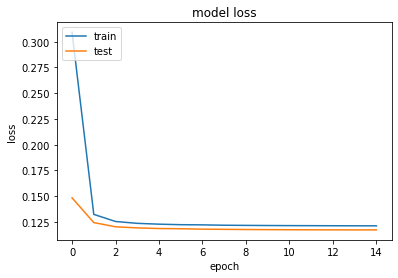

In [73]:
import matplotlib.pyplot as plt

# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
        
##############
# Functions to yield batches for the training
##############


def train_generator(self, batch_size):

    train_gen = InputBatchGenerator(self.X_train, self.y_train, batch_size, self.codes, self.sites, self.dim_msg)

    while True:
        try:
            for B in train_gen.generate_msg_count_batches():
                yield B
        except StopIteration:
            logging.warning("start over generator loop")          

def test_generator(self, batch_size):

    test_gen = InputBatchGenerator(self.X_test, self.y_test, batch_size, self.codes, self.sites, self.dim_msg)
    for B in test_gen.generate_msg_count_batches():
        yield B